In [1]:
#Importing all required libraries
#Created by Sanket Karve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
from matplotlib.ticker import FuncFormatter

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
!pip install PyPortfolioOpt
#Installing the Portfolio Optimzation Library

     |████████████████████████████████| 51kB 1.6MB/s 


In [0]:
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter

In [4]:
tickers = ['AC.TO','ZSP.TO','XFN.TO','HEU.TO','XIT.TO']

thelen = len(tickers)

price_data = []
for ticker in range(thelen):
    prices = web.DataReader(tickers[ticker], start='2013-01-01', end = '2020-06-13', data_source='yahoo')
    price_data.append(prices.assign(ticker=ticker)[['Adj Close']])

df_stocks = pd.concat(price_data, axis=1)
df_stocks.columns=tickers
df_stocks.tail()


AC.TO     ZSP.TO     XFN.TO     HEU.TO     XIT.TO
Date                                                             
2020-06-08  23.389999  47.570000  34.950001  29.490000  36.759998
2020-06-09  21.010000  47.410000  34.599998  27.340000  36.799999
2020-06-10  19.510000  47.099998  34.000000  25.170000  37.070000
2020-06-11  17.850000  45.130001  32.459999  20.400000  36.060001
2020-06-12  19.400000  45.580002  33.080002  21.059999  36.529999

In [5]:
#Checking if any NaN values in the data
nullin_df = pd.DataFrame(df_stocks,columns=tickers)
print(nullin_df.isnull().sum())

AC.TO     0
ZSP.TO    0
XFN.TO    0
HEU.TO    0
XIT.TO    0
dtype: int64


In [0]:
#Annluaized Return
mu = expected_returns.mean_historical_return(df_stocks) 
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df_stocks)

In [8]:
#Max Sharpe Ratio - Tangent to the EF
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe() #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)


OrderedDict([('AC.TO', 0.17255), ('ZSP.TO', 0.21627), ('XFN.TO', 0.0), ('HEU.TO', 0.0), ('XIT.TO', 0.61118)])


In [9]:
ef.portfolio_performance(verbose=True, risk_free_rate = 0.27)
# 2year risk free rate - Treasury Yield 

Expected annual return: 27.4%
Annual volatility: 19.6%
Sharpe Ratio: 0.02


(0.2739192634494637, 0.19627602636892613, 0.01996812102817352)

In [10]:
#Min Volatility Portfolio
ef1 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
minvol=ef1.min_volatility()
minvol_pwt=ef1.clean_weights()
print(minvol_pwt)

OrderedDict([('AC.TO', 0.0), ('ZSP.TO', 0.50243), ('XFN.TO', 0.38576), ('HEU.TO', 0.0), ('XIT.TO', 0.1118)])


In [11]:
ef1.portfolio_performance(verbose=True, risk_free_rate = 0.27)

Expected annual return: 15.0%
Annual volatility: 15.1%
Sharpe Ratio: -0.79


(0.15033765628138043, 0.15123661053722431, -0.7912260351085212)

In [0]:
from pypfopt.cla import CLA
from pypfopt import discrete_allocation

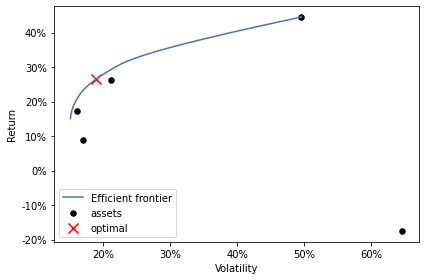

In [13]:
cl_obj = CLA(mu, Sigma)
ax = pplt.plot_efficient_frontier(cl_obj, showfig = False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [14]:
latest_prices = discrete_allocation.get_latest_prices(df_stocks)
# Allocate Portfolio Value in $ as required to show number of shares/stocks to buy, also bounds for shorting will affect allocation
#Min Volatility Portfolio Allocation $10000
allocation_minv, rem_minv = discrete_allocation.DiscreteAllocation(minvol_pwt, latest_prices, total_portfolio_value=10000).lp_portfolio() 
print(allocation_minv)
print("Leftover Fund value in$ after building minimum volatility portfolio is ${:.2f}".format(rem_minv))
print()


{'ZSP.TO': 110.0, 'XFN.TO': 116.0, 'XIT.TO': 31.0}
Leftover Fund value in$ after building minimum volatility portfolio is $16.49



In [15]:
#Max Sharpe Ratio Portfolio Allocation $10000
latest_prices1 = discrete_allocation.get_latest_prices(df_stocks)
allocation_shp, rem_shp = discrete_allocation.DiscreteAllocation(sharpe_pwt, latest_prices1, total_portfolio_value=1000).lp_portfolio() 
print(allocation_shp)
print("Leftover Fund value in$ after building Max Sharpe ratio portfolio is ${:.2f}".format(rem_shp))

#allocation using integer programming via PyPortfolioOpt User Guide
#Alex Putkov code used for guidance and reference in applying integer programming

{'AC.TO': 9.0, 'ZSP.TO': 5.0, 'XIT.TO': 16.0}
Leftover Fund value in$ after building Max Sharpe ratio portfolio is $13.02
